## Environment setup and data pre-processing

In [1]:
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint
from keras.layers import *
from keras.models import Sequential
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

from config import *

df = pd.read_csv("USDJPY.csv", sep='\t')
print(df.count())

# Rename bid OHLC columns
df.rename(columns={'<DATE>': 'timestamp', 
                   '<OPEN>': 'open', 
                   '<CLOSE>': 'close',
                   '<HIGH>': 'high', 
                   '<LOW>': 'low', 
                   '<TICKVOL>': 'volume', 
                   '<VOL>': 'vol', 
                   '<SPREAD>' : 'spread'}, inplace=True)
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y.%m.%d')
df.set_index('timestamp', inplace=True)
df = df.astype(float)

# Add additional features
df['momentum'] = df['volume'] * (df['open'] - df['close'])
df['avg_price'] = (df['low'] + df['high']) / 2
# df['range'] = df['high'] - df['low']
df['ohlc_price'] = (df['low'] + df['high'] + df['open'] + df['close']) / 4
df['oc_diff'] = df['open'] - df['close']

print(df.head())


def create_dataset(dataset, look_back=20):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)


# Scale and create datasets
target_index = df.columns.tolist().index('close')
high_index = df.columns.tolist().index('high')
low_index = df.columns.tolist().index('low')
dataset = df.values.astype('float32')

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# Create y_scaler to inverse it later
y_scaler = MinMaxScaler(feature_range=(0, 1))
t_y = df['close'].values.astype('float32')
t_y = np.reshape(t_y, (-1, 1))
y_scaler = y_scaler.fit(t_y)

X, y = create_dataset(dataset, look_back=50)
y = y[:, target_index]

train_size = int(len(X) * 0.99)
trainX = X[:train_size]
trainY = y[:train_size]
testX = X[train_size:]
testY = y[train_size:]

2024-11-30 10:10:49,018 : INFO : File found at C:\Users\GaDiEL\Documents\ML Projects\FOREX_PM 101\USDJPY.csv. Loading the CSV file...
2024-11-30 10:10:49,041 : INFO : CSV file loaded successfully.


<DATE>       2056
<OPEN>       2056
<HIGH>       2056
<LOW>        2056
<CLOSE>      2056
<TICKVOL>    2056
<VOL>        2056
<SPREAD>     2056
dtype: int64
               open     high      low    close    volume           vol  \
timestamp                                                                
2017-01-02  116.780  117.651  116.634  117.478   43827.0  3.742526e+10   
2017-01-03  117.461  118.602  117.210  117.731  173432.0  1.470914e+11   
2017-01-04  117.720  118.182  117.047  117.214  172525.0  1.414713e+11   
2017-01-05  117.215  117.425  115.213  115.339  222906.0  1.538090e+11   
2017-01-06  115.328  117.175  115.065  116.942  190299.0  1.358805e+11   

            spread    momentum  avg_price  ohlc_price  oc_diff  
timestamp                                                       
2017-01-02     0.0  -30591.246   117.1425   117.13575   -0.698  
2017-01-03     0.0  -46826.640   117.9060   117.75100   -0.270  
2017-01-04     0.0   87297.650   117.6145   117.54075    0.506  

## Model creation

In [2]:
model = Sequential()
model.add(
    Bidirectional(LSTM(30, input_shape=(X.shape[1], X.shape[2]),
                       return_sequences=True),
                  merge_mode='sum',
                  weights=None,
                  input_shape=(X.shape[1], X.shape[2])))
model.add(LSTM(10, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(4, return_sequences=False))
model.add(Dense(4, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1, kernel_initializer='uniform', activation='relu'))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mse'])
print(model.summary())

c:\Users\GaDiEL\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\GaDiEL\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 50, 30)         │        10,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50, 10)         │         1,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 10)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 4)              │           240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,985 (46.82 KB)

 Trainable params: 11,985 (46.82 KB)

 Non-trainable params: 0 (0.00 B)

None


## Model Training

In [4]:
from keras.callbacks import ModelCheckpoint

# Train the model
checkpoint = ModelCheckpoint('bi_rnn_weights.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

# Fit the model to the training data
history = model.fit(trainX, trainY, epochs=50, batch_size=32, validation_data=(testX, testY), callbacks=[checkpoint], verbose=2)

# After training, load the best model weights
model.load_weights('bi_rnn_weights.keras')

# Optionally print the training history (loss and validation loss over epochs)
print("Training Loss:", history.history['loss'][-1])
print("Validation Loss:", history.history['val_loss'][-1])


Epoch 1/50

Epoch 1: val_loss improved from inf to 0.51939, saving model to bi_rnn_weights.keras
62/62 - 3s - 55ms/step - loss: 0.1410 - mae: 0.2565 - mse: 0.1410 - val_loss: 0.5194 - val_mae: 0.7203 - val_mse: 0.5194
Epoch 2/50

Epoch 2: val_loss improved from 0.51939 to 0.27924, saving model to bi_rnn_weights.keras
62/62 - 2s - 39ms/step - loss: 0.0817 - mae: 0.2126 - mse: 0.0817 - val_loss: 0.2792 - val_mae: 0.5279 - val_mse: 0.2792
Epoch 3/50

Epoch 3: val_loss improved from 0.27924 to 0.05441, saving model to bi_rnn_weights.keras
62/62 - 2s - 38ms/step - loss: 0.0230 - mae: 0.0925 - mse: 0.0230 - val_loss: 0.0544 - val_mae: 0.2320 - val_mse: 0.0544
Epoch 4/50

Epoch 4: val_loss improved from 0.05441 to 0.01244, saving model to bi_rnn_weights.keras
62/62 - 2s - 38ms/step - loss: 0.0044 - mae: 0.0434 - mse: 0.0044 - val_loss: 0.0124 - val_mae: 0.1090 - val_mse: 0.0124
Epoch 5/50

Epoch 5: val_loss improved from 0.01244 to 0.00398, saving model to bi_rnn_weights.keras
62/62 - 2s - 37

## Benchmark

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 864ms/step
DatetimeIndex(['2024-11-01', '2024-11-04', '2024-11-05', '2024-11-06',
               '2024-11-07', '2024-11-08', '2024-11-11', '2024-11-12',
               '2024-11-13', '2024-11-14', '2024-11-15', '2024-11-18',
               '2024-11-19', '2024-11-20', '2024-11-21', '2024-11-22',
               '2024-11-25', '2024-11-26', '2024-11-27', '2024-11-28',
               '2024-11-29'],
              dtype='datetime64[ns]', name='timestamp', freq=None)


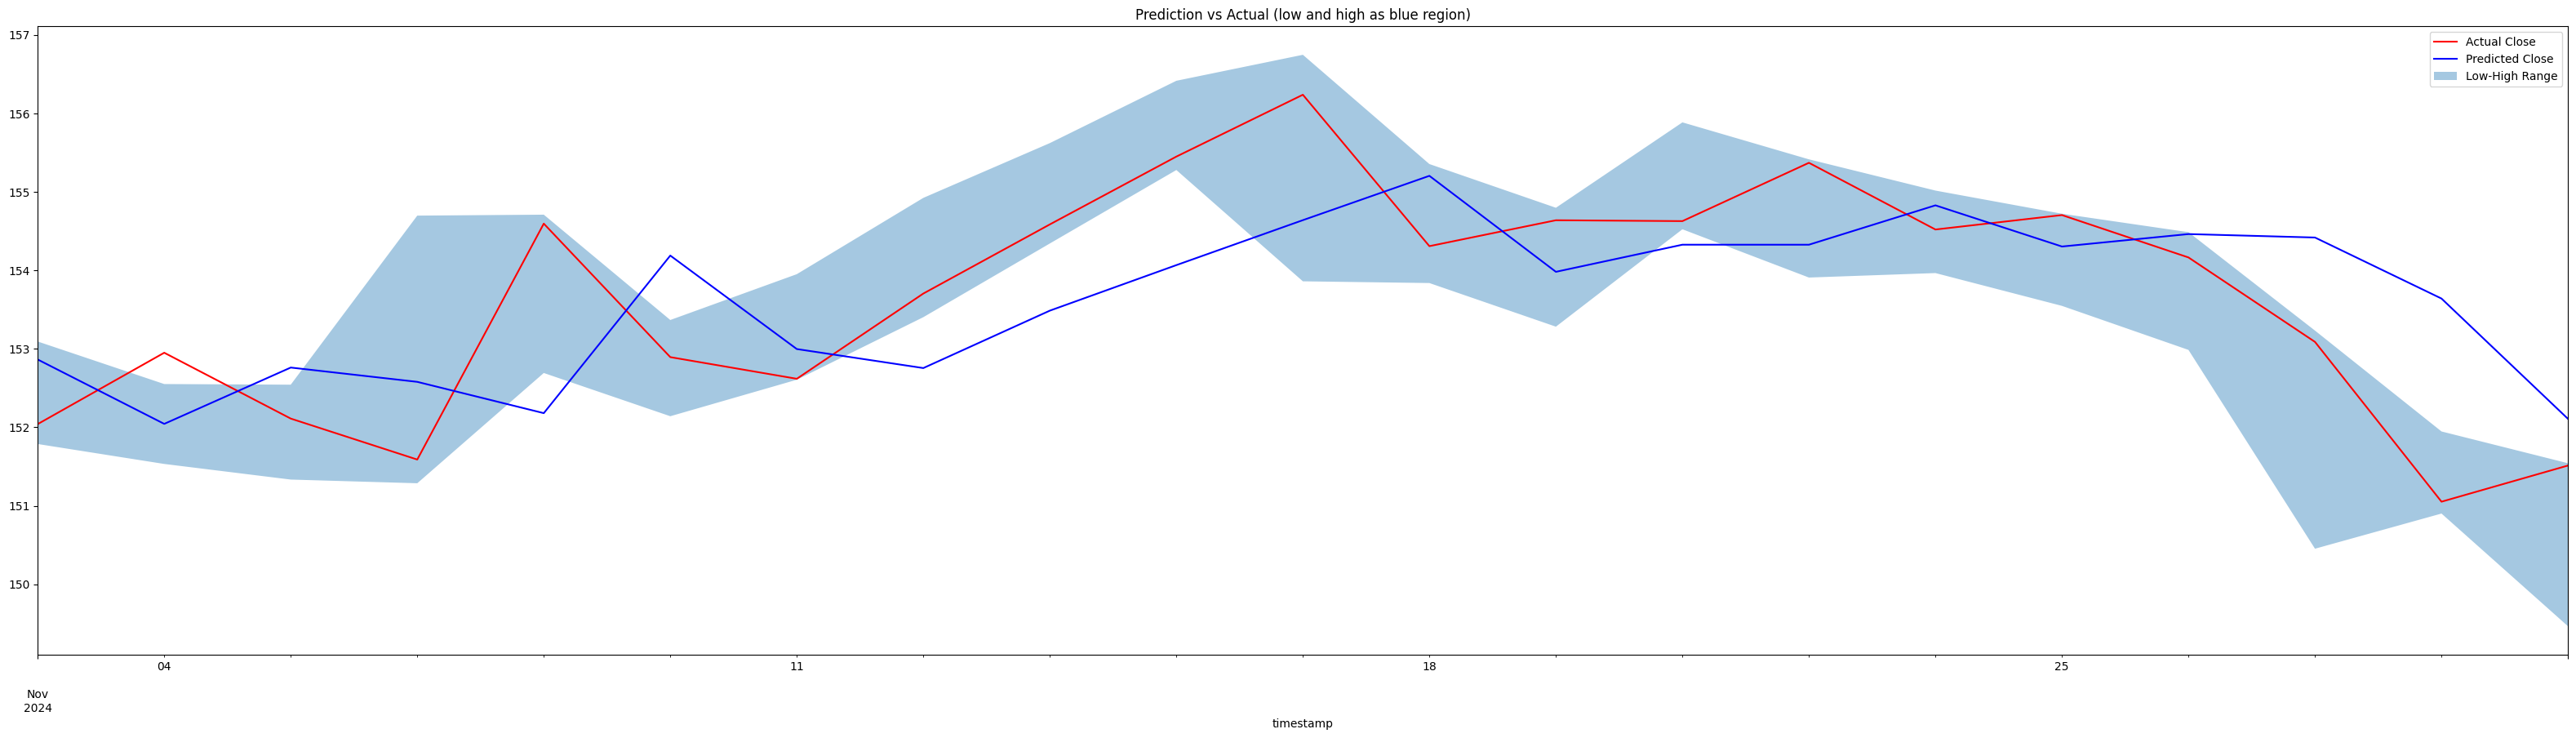

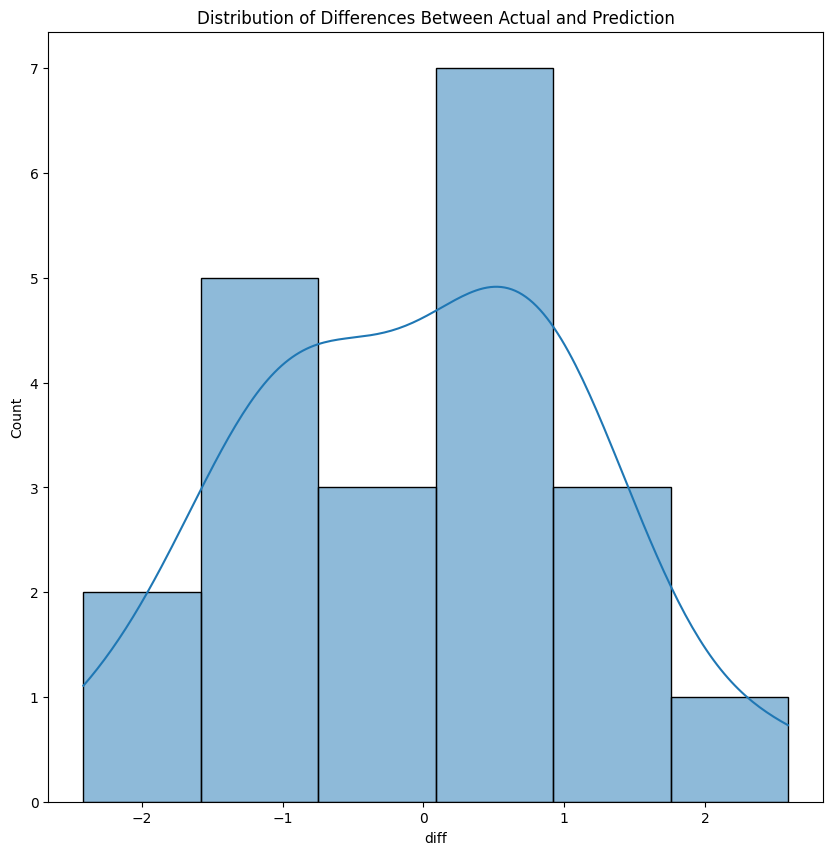

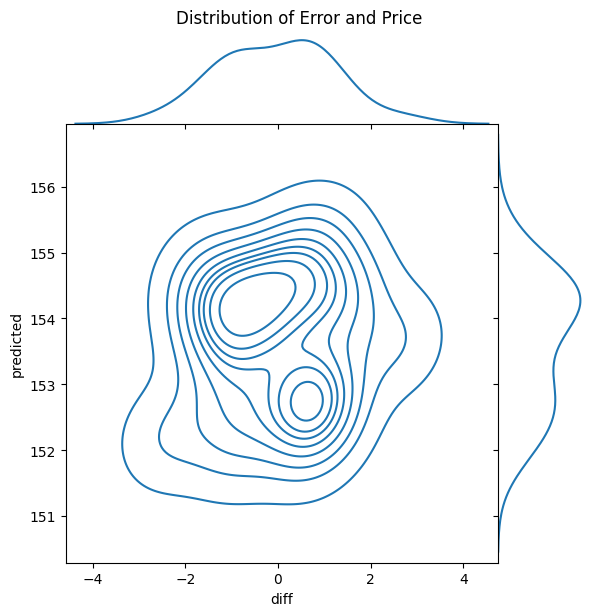

MSE :  1.3668013288018603
MAE :  0.9953220912388393
count    21.000000
mean     -0.028668
std       1.197614
min      -2.414764
25%      -0.949326
50%       0.297943
75%       0.822617
max       2.588287
Name: diff, dtype: float64
Mean Percentage Error: 0.65%
Model Accuracy: 99.35%


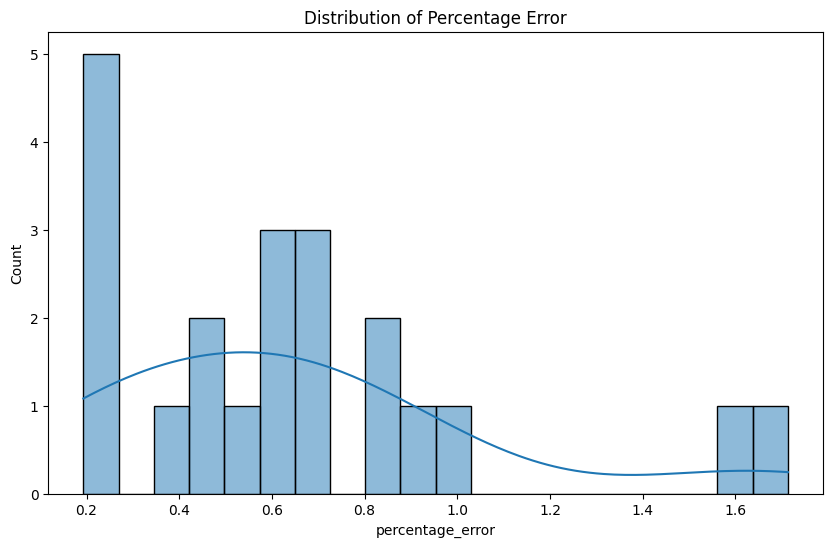

In [5]:
model.load_weights("bi_rnn_weights.keras")

# Make predictions
pred = model.predict(testX)
pred = y_scaler.inverse_transform(pred)  # Inverse scale predictions
close = y_scaler.inverse_transform(np.reshape(testY, (testY.shape[0], 1)))  # Inverse scale actual values

# Prepare predictions DataFrame
predictions = pd.DataFrame()
predictions['predicted'] = pd.Series(np.reshape(pred, (pred.shape[0])))
predictions['close'] = pd.Series(np.reshape(close, (close.shape[0])))

# Slice 'p' from df and ensure it has the correct datetime index
p = df[-pred.shape[0]:].copy()  # Slice the last rows to match the prediction shape
print(p.index)  # Verify it has the correct datetime index

# Assign 'p's index to predictions
predictions.index = p.index

# Ensure predictions contains the necessary columns
predictions = predictions.astype(float)
predictions = predictions.merge(p[['low', 'high']], right_index=True, left_index=True)

# Plotting
# Plot actual and predicted close prices with a red-blue scheme
ax = predictions['close'].plot(color='red', figsize=(40, 10), label='Actual Close')
predictions['predicted'].plot(color='blue', ax=ax, label='Predicted Close')
index = [str(item) for item in predictions.index]
# Fill the region between 'low' and 'high' values
plt.fill_between(x=index, y1=p['low'], y2=p['high'], alpha=0.4, label='Low-High Range')
plt.title('Prediction vs Actual (low and high as blue region)')
plt.legend()
plt.show()

# Other visualizations
# Add a new column for the difference between predicted and actual values
predictions['diff'] = predictions['predicted'] - predictions['close']

# Plot the distribution of differences
plt.figure(figsize=(10, 10))
sns.histplot(predictions['diff'], kde=True)
plt.title('Distribution of Differences Between Actual and Prediction')
plt.show()

# Plot a KDE distribution of error vs predicted prices
sns.jointplot(x="diff", y="predicted", data=predictions, kind="kde", space=0)
plt.suptitle('Distribution of Error and Price', y=1.02)
plt.show()

# Metrics
# Calculate and print MSE and MAE for model evaluation
print("MSE : ", mean_squared_error(predictions['predicted'].values, predictions['close'].values))
print("MAE : ", mean_absolute_error(predictions['predicted'].values, predictions['close'].values))
# Display descriptive statistics for the differences
print(predictions['diff'].describe())

# Calculate percentage error
predictions['percentage_error'] = (abs(predictions['predicted'] - predictions['close']) / predictions['close']) * 100

# Calculate mean percentage error
mean_percentage_error = predictions['percentage_error'].mean()

# Calculate accuracy (as 100% - mean percentage error)
accuracy = 100 - mean_percentage_error

# Print percentage error and accuracy
print(f"Mean Percentage Error: {mean_percentage_error:.2f}%")
print(f"Model Accuracy: {accuracy:.2f}%")

# Optional: Plot the distribution of percentage errors
plt.figure(figsize=(10, 6))
sns.histplot(predictions['percentage_error'], kde=True, bins=20)
plt.title('Distribution of Percentage Error')
plt.show()